- iris  
 => feature 4개
 => target 1개
 => 이진(setosa와 나머지)
- 학습방법: 지도학습, 회귀 
- 알고리즘: 인공신경망(ANN) -> 심층신경망(DNN, 은닉층 많음), MLP(multi-layer perceptron)
- 프레임워크: 파이토치


In [1]:
# 모듈 로딩
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import F1Score, MultilabelConfusionMatrix, MulticlassF1Score
from torchinfo import summary

# 데이터 처리
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

In [2]:
# 패키지 버전 체크
print(f' {torch.__version__}')
print(f' {pd.__version__}')


 2.4.1
 2.0.3


In [3]:
DATAFILE= './data/iris.csv'
irisDF=pd.read_csv(DATAFILE)
irisDF.head(3)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


In [4]:
irisDF['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [5]:
# 타겟 변경 => 정수화, 클래스 2개 (setosa 와 나머지)
# ++replace나 다른 코드 써도 됨
labels=dict(zip(irisDF['variety'].unique().tolist(), range(3)))
irisDF['variety']=irisDF['variety'].replace(labels)
irisDF['variety'].unique()

array([0, 1, 2], dtype=int64)

[2] 모델 클래스 설계 및 정의 <hr>
- 클래스 목적: iris 데이터 학습 및 추론
- 클래스 이름: irisMClf
- 부모 클래스: nn.Module
- 매개변수: 필요없음(입출력 개수 고정)
- 속성/필드: featureDF, targetDF, n_rows, n_features
- 기능/역할: __init__() =>모델 구조 설정, forward() => 순방향 학습// 오버라이딩
- 클래스 구조
    - 입력층: 입력 4개(피쳐) 출력 10개
    - 은닉층: 입력 10개 출력 30개
    - 출력층: 입력 30개 출력 3개  ===> 다중분류

- 손실함수/활성화함수
    - 클래스 형태 ==> nn.ReLU, nn.MSELoss => init()메서드
    - 함수 형태 ==> torch.nn.funtional 아래에 forward() 메서드

In [6]:
class IrisMClfModel(nn.Module):
    
    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self) -> None:
        super().__init__()
        self.in_layer= nn.Linear(4, 10)
        self.hidden_layer= nn.Linear(10, 5)
        self.out_layer= nn.Linear(5, 3)    #다중분류

    # 순방향 학습 진행 메서드
    def forward(self, input_data):
        # 입력층
        y= self.in_layer(input_data)    #변수가 3개 절편이 하나인 식이 퍼셉트론당 1개씩 나옴
        y= F.relu(y)                   #0 ~ y 사이의 값 도출

        # 은닉층
        y= self.hidden_layer(y)         #10개 입력 => 30개 출력
        y= F.relu(y)                   # 0~ y 사이의 값

        # 출력층
        y= self.out_layer(y)            #30개 입력 => 1개 출력 (variety 값)
        # y=F.SoftMax(y)                  #손실함수가 softmax처리 ==> 안넣어도됨
        
        return y

In [7]:
#  모델 인스턴스 생성
model= IrisMClfModel()
print(model)

IrisMClfModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hidden_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=3, bias=True)
)


In [8]:
# 모델 사용 메모리 정보 확인
summary(model, input_size=(10, 4))

Layer (type:depth-idx)                   Output Shape              Param #
IrisMClfModel                            [10, 3]                   --
├─Linear: 1-1                            [10, 10]                  50
├─Linear: 1-2                            [10, 5]                   55
├─Linear: 1-3                            [10, 3]                   18
Total params: 123
Trainable params: 123
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

[3]  데이터셋 클래스 설계 및 정의 <hr>
- 데이터셋: iris.csv
- 피쳐개수: 3개
- 타겟개수: 1개
- 클래스이름: IrisDataset
- 부모클래스: untils.data.Dataset
- 속성/필드: featureDF, TargetDF, n_rows, n_features
- 필수 메서드
    - __init__(self): 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    - __len__(slef): 데이터의 개수 반환
    - __getitem__(self, index): 특정 인덱스의 피쳐와 타겟 반환


In [9]:
class IrisDataset(Dataset):
    def __init__(self, featureDF, targetDF) -> None:
        super().__init__()
        self.featureDF= featureDF
        self.targetDF= targetDF
        self.n_rows= featureDF.shape[0]
        self.n_features= featureDF.shape[1]


    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화 (전결합층=> 기본이 FloatTensor)
        featureTS= torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS= torch.FloatTensor(self.targetDF.iloc[index].values)
        return featureTS, targetTS

In [10]:
print(irisDF[irisDF.columns[-1]].shape)  ##인덱싱으로 추출하면 series, 
print(irisDF[irisDF.columns[-1:]].shape)  # 슬라이싱으로 하면 DF

(150,)
(150, 1)


In [11]:
# 데이터셋 인스턴스 생성 [테스트]
# shape은 항상 2D로!!!
featureDF= irisDF[irisDF.columns[:-1]]
targetDF= irisDF[irisDF.columns[-1:]]
irisDS=IrisDataset(irisDF[irisDF.columns[:-1]], irisDF[irisDF.columns[-1:]])

# 데이터로더 인스턴스 생성
irisDL= DataLoader(irisDS)
for feature, target in irisDL:
    print(feature, target)
    break

tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[0.]])


[4] 학습 준비

In [12]:
# 학습 진행 관련 설정값

EPOCH= 100
BATCH_SIZE= 10  #버리는 데이터 없게 하려면 전체 데이터 수를 보고 조절
DEVICE= 'cuda' if torch.cuda.is_available() else 'cpu'
LR= 0.001

In [13]:
# 모델 인스턴스
model= IrisMClfModel()
# 데이터셋 인스턴스 (데이터 분리)
X_train, X_test, Y_train, Y_test= train_test_split(featureDF, targetDF, random_state=1)
X_train, X_val, Y_train, Y_val= train_test_split(X_train, Y_train, random_state=1)
print(X_train.shape, X_test.shape, X_val.shape)


irisDS= IrisDataset(X_train, Y_train) #검증용 데이터 클래스로 만들기 싫으면 나중에 텐서로 변환후 넣으면 됨
valDS=IrisDataset(X_val, Y_val)
testDS= IrisDataset(X_test, Y_test)
# 데이터로더 인스턴스 
irisDL= DataLoader(irisDS, batch_size= BATCH_SIZE)
len(irisDL)

(84, 4) (38, 4) (28, 4)


9

In [14]:
# 데이터로더 테스트
for feature, target in irisDL:
    print(feature.shape, target.shape)

torch.Size([10, 4]) torch.Size([10, 1])
torch.Size([10, 4]) torch.Size([10, 1])
torch.Size([10, 4]) torch.Size([10, 1])
torch.Size([10, 4]) torch.Size([10, 1])
torch.Size([10, 4]) torch.Size([10, 1])
torch.Size([10, 4]) torch.Size([10, 1])
torch.Size([10, 4]) torch.Size([10, 1])
torch.Size([10, 4]) torch.Size([10, 1])
torch.Size([4, 4]) torch.Size([4, 1])


In [15]:
# 최적화 인스턴스
# => w, b, model.parameters 전달
optimizer= optim.Adam(model.parameters(), lr=LR)


# 손실함수 인스턴스
# => Binary Cross Entropy Loss -> 이진분류 (예측값을 확률값으로 전달-> sigmoid처리 해야함)
MClfLoss=nn.CrossEntropyLoss()


[5] 학습진행

In [16]:
len(X_train), X_train.__len__()

(84, 84)

In [17]:
# 손실과 성능지표값 저장 => 학습의 효과 확인
LOSS_HISTORY, SCORE_HISTORY= [[],[]], [[],[]]
CNT= len(irisDL)
print(f' BATCH_CNT: {CNT}')
# 학습 모드로 모델 설정 (코딩 스타일에 따라 위치 상이)

for epoch in range(EPOCH):                      #만약 검증을 한다면 Custom Dataset 만들어야함
    print(f'{epoch+1}/{EPOCH}')
    model.train()

    # 배치크기 만큼 데이터 로딩에서 학습 진행
    loss_total, score_total= 0,0
    for featureTS, targetTS in irisDL:
        # 학습 진행
        pre_y= model(featureTS)

        # 손실 계산 ==> CE 는 타겟이 0 또는 1차원, type은 long
        loss= MClfLoss(pre_y, targetTS.reshape(-1).long())
        loss_total+=loss.item()
        # 성능 평가  => MF1 => target 0차원
        score= MulticlassF1Score(num_classes=3)(pre_y, targetTS.reshape(-1))
        score_total+= score.item()

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 에포크당 검증기능
    # 검증 모드
    model.eval()
    with torch.no_grad():
        # 검증 데이터 셋
        val_featureTS=torch.FloatTensor(valDS.featureDF.values) #values -> array로 변경
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)

        # 학습/추론론
        pre_val=model(val_featureTS)

        # 손실
        loss_val=MClfLoss(pre_val, val_targetTS.reshape(-1).long())

        # 평가
        score_val=MulticlassF1Score(num_classes=3)(pre_val, val_targetTS.reshape(-1))



    # 손실값과 성능평가값 저장
    # 학습
    LOSS_HISTORY[0].append(loss_total/BATCH_SIZE)
    SCORE_HISTORY[0].append(score_total/BATCH_SIZE)
    print(f'Train\n Loss: {loss_total/BATCH_SIZE}\n Score: {score_total/BATCH_SIZE}')
    # 검증
    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)
    print(f'Val\n Loss: {loss_val}\n Score: {score_val}')

 BATCH_CNT: 9
1/100
Train
 Loss: 1.0634784698486328
 Score: 0.13131535425782204
Val
 Loss: 1.1463086605072021
 Score: 0.20000000298023224
2/100
Train
 Loss: 1.022238826751709
 Score: 0.13131535425782204
Val
 Loss: 1.1078094244003296
 Score: 0.20000000298023224
3/100
Train
 Loss: 0.9897227048873901
 Score: 0.13131535425782204
Val
 Loss: 1.0761122703552246
 Score: 0.20000000298023224
4/100
Train
 Loss: 0.9651663184165955
 Score: 0.13131535425782204
Val
 Loss: 1.0530568361282349
 Score: 0.3162393271923065
5/100
Train
 Loss: 0.955583655834198
 Score: 0.2658252909779549
Val
 Loss: 1.043823003768921
 Score: 0.5185185074806213
6/100
Train
 Loss: 0.9504834413528442
 Score: 0.30063973665237426
Val
 Loss: 1.0311651229858398
 Score: 0.4777183532714844
7/100
Train
 Loss: 0.9438556432723999
 Score: 0.25514189898967743
Val
 Loss: 1.0208631753921509
 Score: 0.35330259799957275
8/100
Train
 Loss: 0.9371866822242737
 Score: 0.24721260517835617
Val
 Loss: 1.0098097324371338
 Score: 0.35330259799957275
9

In [18]:
# 에포크당 검증기능
    # 테스트
model.eval()
with torch.no_grad():
    # 검증 데이터 셋
    val_featureTS=torch.FloatTensor(valDS.featureDF.values) #values -> array로 변경
    val_targetTS=torch.FloatTensor(valDS.targetDF.values)

    # 학습/추론론
    pre_test=model(val_featureTS)

    # 손실
    loss_test=MClfLoss(pre_val, val_targetTS.reshape(-1).long())

    # 평가
    score_test=MulticlassF1Score(num_classes=3)(pre_val, val_targetTS.reshape(-1))

- 학습결과 체크 => 학습과 검증의 loss, score 변화 확인

In [19]:
train_loss, train_score=[],[]
val_loss, val_score=[],[]

In [20]:
# for i in LOSS_HISTORY[0]:
#     train_loss.append(i.detach().numpy())
#     print(train_loss)
# for i in LOSS_HISTORY[1]:
#     val_loss.append(i.detach().numpy())

# for i in SCORE_HISTORY[0]:
#     train_score.append(i.detach().numpy())
# for i in SCORE_HISTORY[1]:
#     val_score.append(i.detach().numpy())

In [21]:
model.eval()
torch
a= irisDF.iloc[1][:-1]
# a=torch.FloatTensor(a).reshape(1,-1)
# model(a)
# a=F.softmax(a, dim=1)
# a


In [22]:
# pre_val=F.softmax(pre_val, dim=1)
#         a= pre_val.argmax().item()
#         print(f'{result[0]}: {pre_val[0]}')
#         return result[0], pre_val[0]

In [23]:
from get_train_model import predicting
predicting(model, a, type='multiclass', result=['Setosa', 'Versicolor', 'Virginica'])

Setosa: 0.9654


Text(0.5, 1.0, 'Train & Val Score')

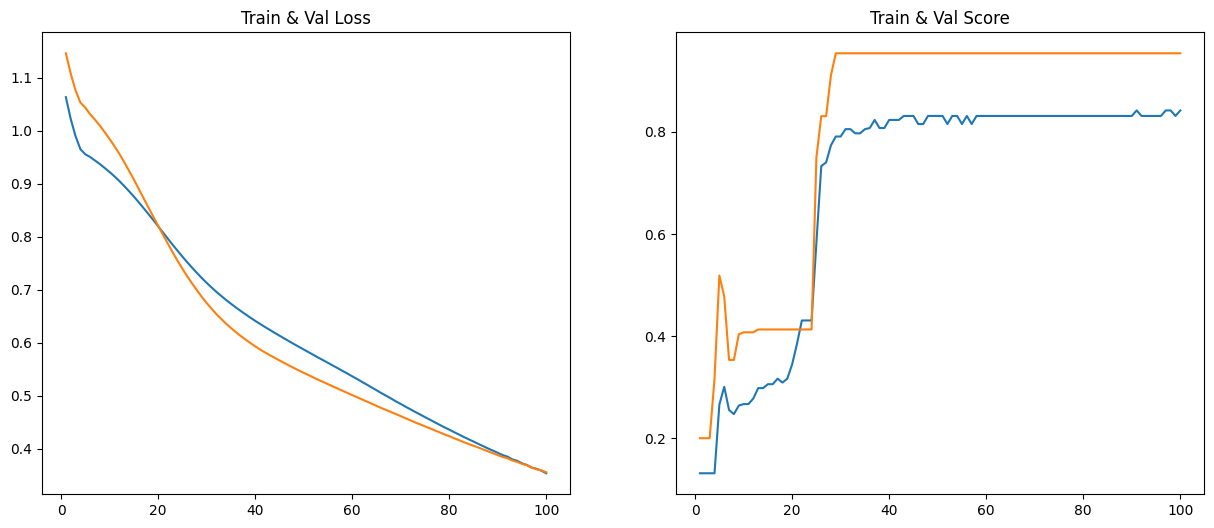

In [24]:
# 변화 시각화

fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15,6))
ax1.plot(range(1,EPOCH+1), LOSS_HISTORY[0][:EPOCH], label='Train')
ax1.plot(range(1,EPOCH+1), LOSS_HISTORY[1][:EPOCH], label='Val')
ax1.set_title('Train & Val Loss')
ax2.plot(range(1, EPOCH+1), SCORE_HISTORY[0][:EPOCH], label='Train')
ax2.plot(range(1, EPOCH+1), SCORE_HISTORY[1][:EPOCH], label='Val')
ax2.set_title('Train & Val Score')